#### This notebook is WIP!

Having explored how MHA can be used inside encoder to generate meaningful embeddings that could be used for classification (`mha_classifier.ipynb`) it only seems right to explore how it works not only inside Encoder-only architectures, but Encoder-Decoder as well. Hence, this notebook is going to be dedicated to coding up the whole transformer from scratch. Just a little reminder, here's how the architecture of the Transformer looks:

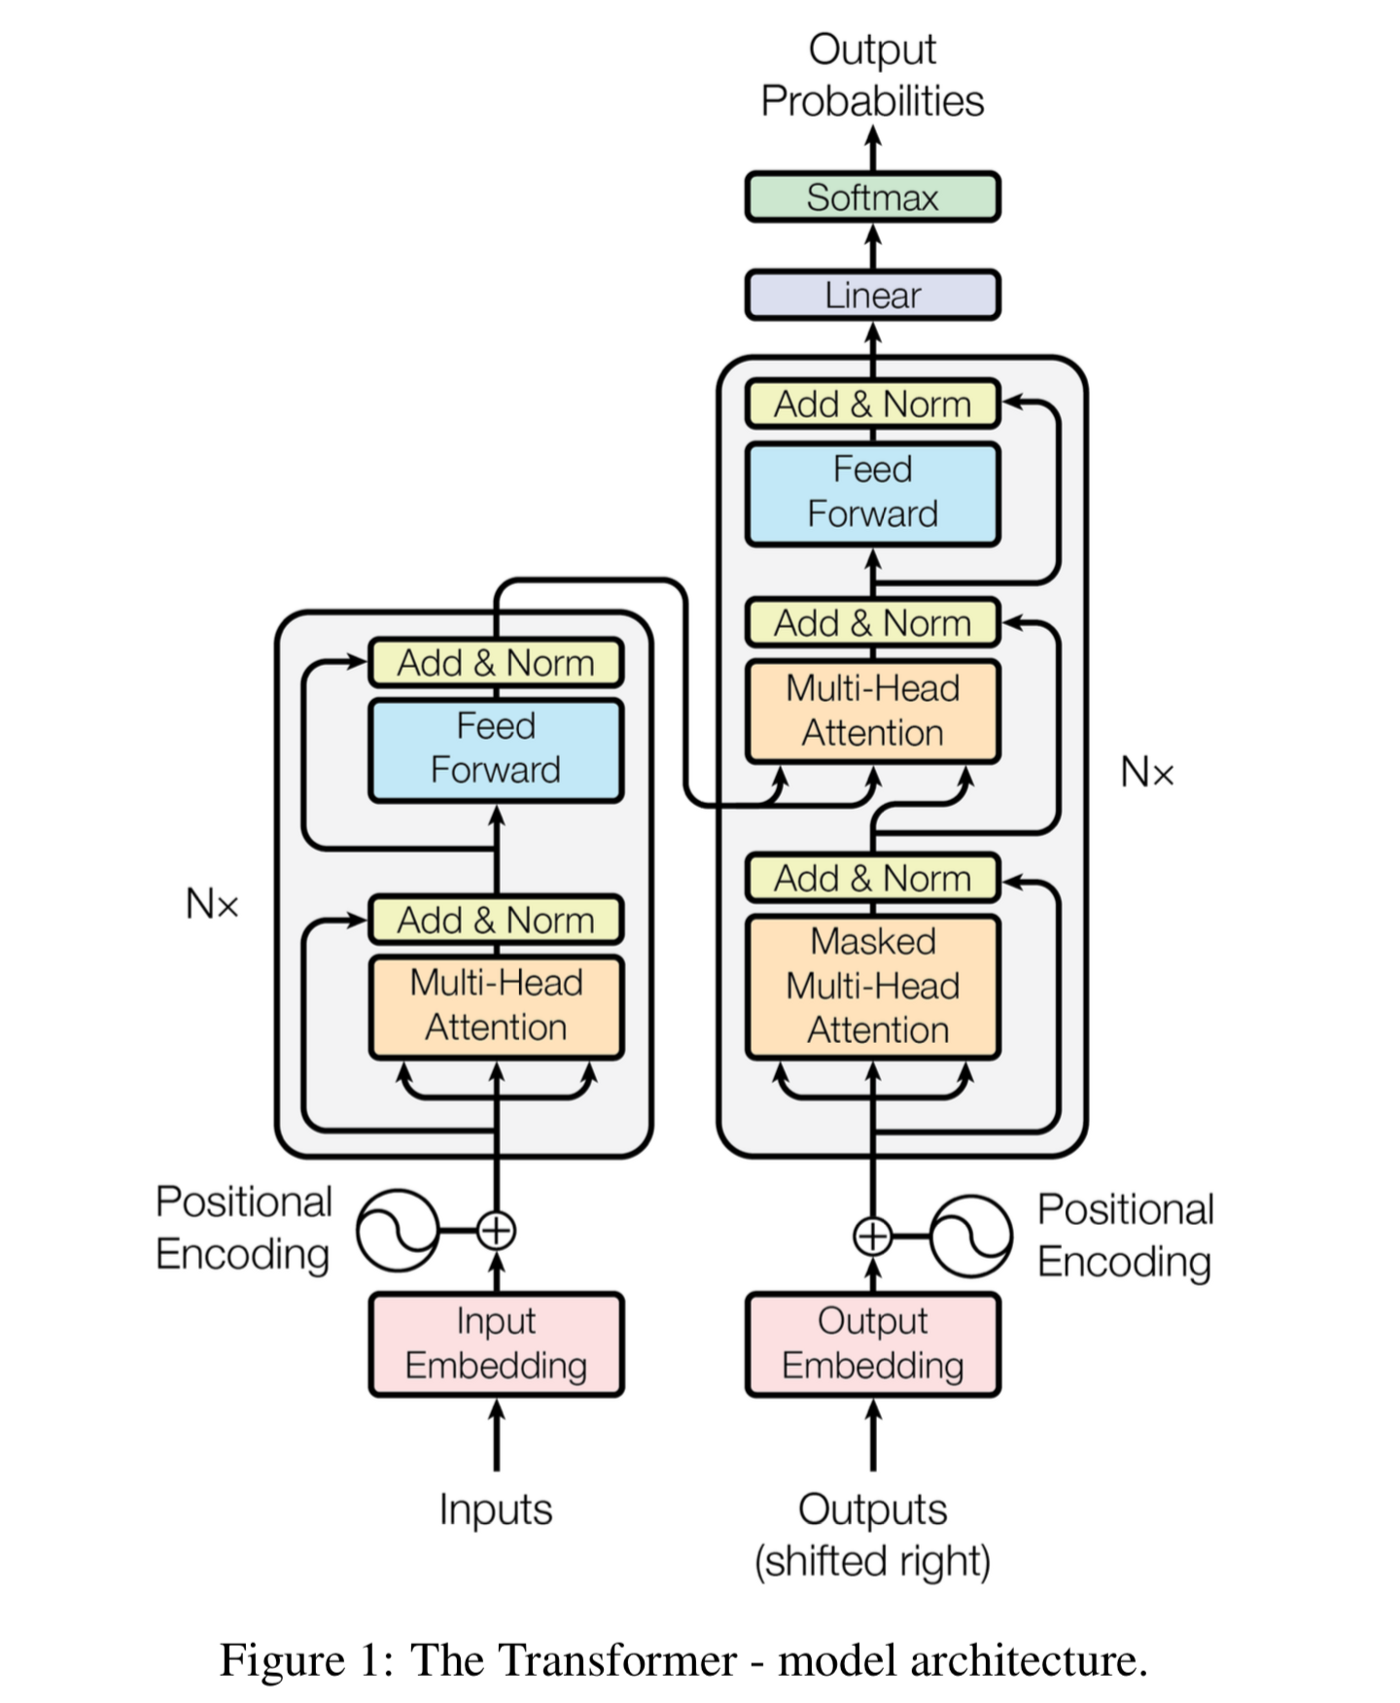

#### Preparing the dataset
For the demo we can load up the wikitext dataset from Hugginface. Then we'll build a preprocessing pipeline using tokenizers and then tokenize our sequence by training the Unigram tokenizer.

In [6]:
from datasets import load_dataset

dataset = load_dataset("wikitext", name="wikitext-2-raw-v1", split="train")
sample_size = 10
dataset.select(torch.randperm(len(dataset))[:sample_size])['text']

['',
 '',
 '',
 '',
 ' The Mozambican War of Independence was an armed conflict between the guerrilla forces of the Mozambique Liberation Front or FRELIMO ( Frente de Libertação de Moçambique ) , and Portugal . The war officially started on September 25 , 1964 , and ended with a ceasefire on September 8 , 1974 , resulting in a negotiated independence in 1975 . \n',
 ' = = Work = = \n',
 ' = = Referendum and declaration of independence = = \n',
 '',
 ' Dylan commenced the new millennium by winning the Polar Music Prize in May 2000 and his first Oscar ; his song " Things Have Changed " , written for the film Wonder Boys , won an Academy Award in March 2001 . The Oscar , by some reports a facsimile , tours with him , presiding over shows perched atop an amplifier . \n',
 '']

Next step is building a normalization pipeline for the Unigram tokenizer, a pretty good model that is aimed to build representations of words based off the general joint probability distribution of all possible subsequences:

In [7]:
from tokenizers import (
    decoders,
    models,
    Regex,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

# initializing the tokenizer
tokenizer = Tokenizer(models.Unigram())

# normilising pipeling
tokenizer.normalizer = normalizers.Sequence(
    [
        # replace quotation marks with their universal standard
        normalizers.Replace("``", '"'),
        normalizers.Replace("''", '"'),

        # one of the best normalization technique that brings
        # all symbols to their best compatible analogue, e.g.
        # ① -> 1 or ™ -> T M 
        normalizers.NFKD(),

        # additional normalization technique that does á -> a
        normalizers.StripAccents(),

        # replace two or more spaces with a single one
        normalizers.Replace(Regex(" {2,}"), " "),
    ]
)

Now we're ready to set up the training of the Unigram tokenizer preliminary initializing special tokens, that are needed later for a better dictionary representation:

In [8]:
special_tokens = ["<sep>", "<unk>", "<pad>", "<s>", "</s>"]
trainer = trainers.UnigramTrainer(
    vocab_size=32000, special_tokens=special_tokens, unk_token="<unk>"
)
tokenizer.train_from_iterator(dataset['text'], trainer=trainer)

After running the training we can test the tokenizer on the arbitrary sequence:

In [45]:
enc = tokenizer.encode("The goalkeeper's hit 9 times.")
print(enc.tokens, enc.ids)

['The ', 'go', 'al', 'keep', 'er', "'s ", 'hit ', '9 ', 'time', 's', '.'] [163, 2069, 291, 25105, 269, 17, 962, 422, 11085, 43, 166]


After creating a normalization pipeline and training our tokenizer we can create a seperate dataset on top of the wikiset dataset that handles truncations and additional preprocessing (e.g. replacing OOV tokens with \<unk\>):

In [47]:
from torch.utils.data import Dataset
import torch

textual_params = {
    'max_seq': 512
}

def preprocess(tokenizer, token: str):
    """  
    Preprocessses each token with a corresponding ID from the vocabulary
    """
    token2id = tokenizer.token_to_id(token)
    return tokenizer.token_to_id('<unk>') if token2id is None else \
        tokenizer.token_to_id('<sep>') if token == ' ' else token2id

def pad_trunc_sequence(seq: list) -> list:
    """ 
    Adds <s> in the beggining and </s> in the end.
    Also adds pad tokens to the sequence if it has fewer tokens than
    maximum sequence length. Otherwise truncates it. 
    """
    if len(seq) < textual_params['max_seq']:
        seq += [tokenizer.token_to_id('</s>')]
        seq += [tokenizer.encode('<pad>').ids[0] \
                           for _ in range(textual_params['max_seq'] - len(seq))]
        return [tokenizer.token_to_id('<s>')] + seq
    else:
        return [tokenizer.token_to_id('<s>')] + \
            seq[:textual_params['max_seq']] + [tokenizer.token_to_id('</s>')]

class texts2id_dataset(Dataset):
    def __init__(self, ds):
        """ 
        - ds: datasets.arrow_dataset.Dataset
            - Expects a dataset of items with the key of "text"
            corresponding to text sequences
        """
        self.texts = ds['text']
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        sequences = []
        
        # check whether index is single and thus we have to iterate
        # over just one sequence rather than multiple ones
        iterated_sequences = [self.texts[index]] if isinstance(index, int) \
            else self.texts[index]
        for seq in iterated_sequences:
            tokens2ids = torch.tensor(pad_trunc_sequence([
                preprocess(tokenizer, text) for text in \
                    tokenizer.encode(seq).tokens
            ]),  dtype=torch.long)
            sequences.append(tokens2ids)

        return torch.vstack(sequences)
    
ds = texts2id_dataset(dataset)
ds[5]

tensor([[    3,  5018,  4104,  1791,  2750,  3184,    19, 22613,   160,   927,
             6,  1134,   895,   197,  9404,    45,   283, 12108,  2063,   887,
            36,  2604,  2979,  2273, 13839,  8804,  4905,   115,  5509,     6,
         14328,   917,  7392,   249,  4721,   534,  9414,  9311, 22342,     5,
         19522, 20278,   360, 20263,    57,    13,  4216,  8655, 17405,    28,
          1657,  2604,  2979,  4743, 13754, 24878,   166, 21420,   155,  9689,
          5307,    97,  2252,  9311,    53,  8553,  3593,  4535,    20, 13627,
           224,     8,     9,     4,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,  

#### Building an embedding module 
First step is creating an embedding module that will learn the most meaningful representation of words based on some vocabulary we've obtained after tokenization. For the sake of simplicity both token embeddings and positional embeddings are going to be learnable

In [78]:
import torch
from torch import nn
import torch.nn.functional as F

class Embedding(nn.Module):

    def __init__(self, vocab_size, embed_d, max_seq_len,
                 dropout=.01, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        # each word in vocabulary is going to get its 
        # vector representation
        self.max_seq_len = max_seq_len+1
        self.tokenEmbed = nn.Embedding(vocab_size,embed_d)
        self.posEmbed = nn.Embedding(self.max_seq_len,embed_d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """ 
        Expects sequences of token indices
        """
        batch_size = x.shape[0]

        # expanding range [0, max_seq_len]=seq_range to 
        # [seq_range,seq_range,...,] tensor of batch_size
        pos = torch.arange(0, self.max_seq_len).expand(
            batch_size, self.max_seq_len
        )
        emb = self.tokenEmbed(x) + self.posEmbed(pos)
        return self.dropout(emb)

Having coded an Embedding layer we can now use it on the dataset of indices to sample an embedding for each token:

In [79]:
emb = Embedding(vocab_size=32000,embed_d=256,max_seq_len=512)
emb(ds[1])

tensor([[[ 0.8678, -2.0291, -0.1898,  ...,  1.0854,  0.3659,  0.6391],
         [ 3.3702, -1.4133,  0.6733,  ...,  1.1812, -1.9215, -0.2611],
         [-0.5714,  0.9576, -2.3153,  ..., -1.3859,  1.0478,  0.0523],
         ...,
         [ 0.4009,  1.4868,  0.7471,  ..., -1.0871,  0.9809, -0.8919],
         [ 0.0635,  0.9513, -1.2138,  ..., -1.2032,  0.8574, -1.8689],
         [ 0.3621,  2.6178, -1.0196,  ..., -1.5092,  0.1529, -2.4265]]],
       grad_fn=<MulBackward0>)

#### Coding up the MQA

Next we can move on to coding up an attention layer of the Transformer. Instead of MHA, we're going to be creating MQA (Multi-Query Attention) (https://arxiv.org/pdf/1911.02150) that has proven to yeild better results and is used in SOTA LLMs like Gemma (https://arxiv.org/pdf/2403.08295)

In [137]:
class MQA(nn.Module):

    def __init__(self, embed_d, max_seq_len, q_n, *args, **kwargs) -> None:
        """ 
        - embed_d: int
            - embedding dimensions
        - max_seq_len: int
            - maximum length of a sentence
        - q_n: int
            - number of Q heads
        """
        super().__init__(*args, **kwargs)
        self.max_seq_len = max_seq_len + 1
        self.d = embed_d
        self.num_q = q_n
        self.outProj = nn.Linear(self.max_seq_len*self.num_q,self.max_seq_len,bias=False)
        self.Qs = nn.ModuleList([
            nn.Linear(self.d,self.d) for _ in range(self.num_q)
        ])
        self.K = nn.Linear(self.d,self.d)
        self.V = nn.Linear(self.d,self.d)

    def self_att(self, Q, K, V, mask=None):
        """ 
        Apply a single self-attention on a set of Q,K,V matrices
        """
        att_matrix = torch.einsum('bjk,bkl -> bjl', Q, K.permute(0, 2, 1))
        att_matrix = torch.softmax(att_matrix/self.d**.5, dim=-1)
        if mask is not None:
            att_matrix = att_matrix.masked_fill(mask == 0, float("-1e20"))
        return torch.einsum('bjk,bkl -> bjl',att_matrix,V)

    def forward(self, key, query, x, mask=None):
        K = self.K(key)
        V = self.V(x)
        Qs = torch.cat([
            self.self_att(q(query), K, V, mask) for q in self.Qs
        ], dim=1).permute(0,2,1)
        return self.outProj(Qs).permute(0,2,1)

Having coded up the MQA we can recreate a self-attention mechanism by applying MQA on the single embedding:

In [140]:
mqa = MQA(embed_d=256,max_seq_len=512,q_n=6)
x = emb(ds[1])
mqa(x, x, x), mqa(x, x, x).shape

(tensor([[[-0.0158,  0.0088, -0.0138,  ...,  0.0371,  0.0080,  0.0560],
          [ 0.0854, -0.0671, -0.0048,  ..., -0.1365, -0.0085, -0.1547],
          [ 0.1928, -0.1750, -0.0507,  ..., -0.2815,  0.0093, -0.3397],
          ...,
          [ 0.0324, -0.0350, -0.0197,  ..., -0.0729,  0.0120, -0.0893],
          [ 0.1106, -0.0994, -0.0119,  ..., -0.1629, -0.0142, -0.1795],
          [ 0.0664, -0.0590, -0.0157,  ..., -0.1272,  0.0056, -0.1543]]],
        grad_fn=<PermuteBackward0>),
 torch.Size([1, 513, 256]))

#### Encoder
First we build a so-called transformer block that is used in both encoder and decoder blocks of the Transformer

In [142]:
class TransformerBlock(nn.Module):

    def __init__(self, embed_d, max_seq_len, 
                 q_n, gamma=1, dropout=.1, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        # MQA and LayerNorm blocks
        self.mqa = MQA(embed_d,max_seq_len,q_n)
        self.norm = nn.LayerNorm(embed_d)

        # feed-forward block
        self.ff = nn.Sequential(
            nn.Linear(embed_d,embed_d*gamma),
            nn.GELU(),
            nn.Linear(embed_d*gamma,embed_d)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, k, q, x, mask=None):
        # get attention matrix
        att_matrix = self.mqa(k,q,x,mask)
        
        # resid connection on att_out and x (V matrix)
        x += att_matrix

        # apply LayerNorm and FF
        normed_x = self.norm(x)
        x_through_ff = self.ff(x)

        # resid connection on FF and first normed outputs
        x = normed_x + x_through_ff

        return self.dropout(self.norm(x))


After preparing a universal Transformer Block we can get down to coding up the Encoder block

In [143]:
class EncoderBlock(nn.Module):

    def __init__(self, embed_d, vocab_size, max_seq_len, 
                 q_n, n_blocks=6, gamma=1, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.embedder = Embedding(vocab_size,embed_d,
                                  max_seq_len)
        self.transformerBlocks = nn.ModuleList([
            TransformerBlock(embed_d, max_seq_len, q_n, gamma) 
            for i in range(n_blocks)
        ])
    
    def forward(self, x):
        x = self.embedder(x)
        for block in self.transformerBlocks:
            x = block(x, x, x)
        return x

#### Decoder
Now the most interesting part - coding the decoder block of the Transformer. We'll have to create an expanded version of the transformer block, since the decoder block of the Transformer contains additional layers

In [144]:
class TransformerBlockForDecoder(nn.Module):
    
    def __init__(self, embed_d, max_seq_len, 
                 q_n, gamma=4, dropout=.2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.mqa = MQA(embed_d,max_seq_len,q_n)
        self.norm = nn.LayerNorm(embed_d)
        self.dropout = nn.Dropout(dropout)
        self.transformerBlock = TransformerBlock(
            embed_d,max_seq_len,q_n,gamma,dropout
        )

    def forward(self, k, q, x, mask):
        decoder_V_att = self.mqa(x,x,x,mask)
        decoder_V = self.dropout(self.norm(decoder_V_att + x))
        decoder_att_out = self.transformerBlock(k, q, decoder_V)
        return decoder_att_out 

class DecoderBlock(nn.Module):
    
    def __init__(self, embed_d, vocab_size, max_seq_len, 
                 q_n, n_blocks=6, dropout=.2, gamma=4, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.embedder = Embedding(vocab_size, embed_d, 
                                  max_seq_len)
        
        self.decoderBlocks = nn.ModuleList([
            TransformerBlockForDecoder(
                embed_d,max_seq_len,q_n,gamma
            ) for i in range(n_blocks)
        ])
        self.dropout= nn.Dropout(dropout)
    
    def forward(self, x, enc_output, mask):
        x = self.dropout(self.embedder(x))
        for block in self.decoderBlocks:
            x = block(enc_output, x, enc_output, mask)
        return x

#### Building the transformer
This concludes the build of preliminary modules with which we're able to build the transformer network

In [145]:
class Transformer(nn.Module):

    def __init__(self, embed_d, vocab_size, target_vocab_size,
                 max_seq_len, num_q, num_enc_blocks, num_dec_blocks, 
                 gamma=4, dropout=.2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.encoder = EncoderBlock(embed_d,vocab_size,
                                    max_seq_len,
                                    num_q,num_enc_blocks,
                                    gamma)
        self.decoder = DecoderBlock(embed_d,
                                    target_vocab_size,
                                    max_seq_len,
                                    num_q,num_dec_blocks,
                                    gamma=gamma)
        self.fc_out = nn.Linear(embed_d,target_vocab_size)

    def make_target_mask(self, target):
        """ 
        Returns triangular matrix with elements above the
        main diagonal inside batches being 0
        """
        batch_size, mask_len = target.shape
        return torch.tril(torch.ones(
            mask_len,mask_len
        )).expand(batch_size,1,mask_len,mask_len)
    
    def forward(self, inp, out):
        mask = self.make_target_mask(out)
        enc_out = self.encoder(inp)
        dec_out = self.decoder(out, enc_out, mask)
        return F.softmax(self.fc_out(dec_out), dim=-1)

In [146]:
src = ds[2]
target = ds[3]

model = Transformer(embed_d=256,
                    vocab_size=32000,
                    target_vocab_size=32000,
                    max_seq_len=512,
                    num_enc_blocks=6,
                    num_dec_blocks=6,
                    gamma=4,
                    num_q=8)
model(src, target)

RuntimeError: einsum(): the number of subscripts in the equation (3) does not match the number of dimensions (4) for operand 0 and no ellipsis was given